In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.neighbors import KNeighborsClassifier


In [25]:
# PART 2: Character Chain Generation

SUPPORTED_CHARS = ['(', ')', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
                   't', 'x', 'y', ',', '+', '-', '*']

def load_character_image(dataset_dir, char):
    """Загружает случайное изображение символа из валидационного набора"""
    char_folder = os.path.join(dataset_dir, char if char != 'x' else 'X')
    images = sorted([f for f in os.listdir(char_folder) if os.path.isfile(os.path.join(char_folder, f))])
    
    # Берём 20% последних изображений (валидационный набор)
    validation_split = int(len(images) * 0.8)
    validation_images = images[validation_split:]
    
    image_path = os.path.join(char_folder, random.choice(validation_images))
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

def generate_character_sequences(dataset_dir, num_sequences=3, chain_length=4):
    """Генерирует N случайных цепочек символов"""
    sequences = []
    image_sets = []
    
    for _ in range(num_sequences):
        # Создаём случайную цепочку
        chain = ''.join(random.choices(SUPPORTED_CHARS, k=chain_length))
        
        # Загружаем изображения для каждого символа
        images = [load_character_image(dataset_dir, char) for char in chain]
        images = [img for img in images if img is not None]
        
        sequences.append(chain)
        image_sets.append(images)
        print(f"Цепочка: '{chain}'")
    
    return sequences, image_sets

# Инициализация
print(f"Поддерживаемые символы: {SUPPORTED_CHARS}\n")
generated_sequences, generated_image_sets = generate_character_sequences('./data', num_sequences=3, chain_length=4)


Поддерживаемые символы: ['(', ')', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 't', 'x', 'y', ',', '+', '-', '*']

Цепочка: 'tx39'
Цепочка: '2513'
Цепочка: '499-'


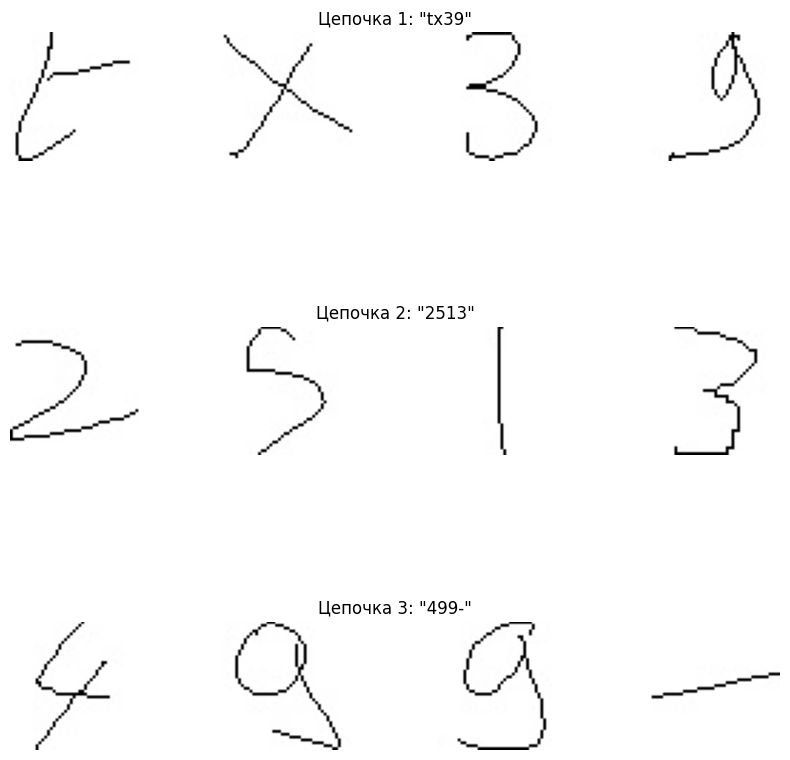

In [26]:
# PART 3: Combining and Visualizing Character Chains

def combine_images_horizontally(image_list, gap=20):
    """Объединяет изображения символов в одно горизонтальное изображение"""
    total_width = sum(img.shape[1] for img in image_list) + gap * (len(image_list) - 1)
    max_height = max(img.shape[0] for img in image_list)
    
    combined = np.ones((max_height, total_width), dtype=np.uint8) * 255
    current_x = 0
    
    for img in image_list:
        height, width = img.shape
        y_offset = (max_height - height) // 2
        combined[y_offset:y_offset+height, current_x:current_x+width] = img
        current_x += width + gap
    
    return combined

def visualize_chains(combined_images, sequences):
    """Визуализирует цепочки символов"""
    fig, axes = plt.subplots(len(combined_images), 1, figsize=(8, 10))
    if len(combined_images) == 1:
        axes = [axes]
    
    for idx, (img, seq) in enumerate(zip(combined_images, sequences)):
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f'Цепочка {idx+1}: "{seq}"')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Объединение и визуализация
final_combined_images = [combine_images_horizontally(imgs, gap=30) for imgs in generated_image_sets]
visualize_chains(final_combined_images, generated_sequences)


Обрабатываем цепочку 1: 'tx39'


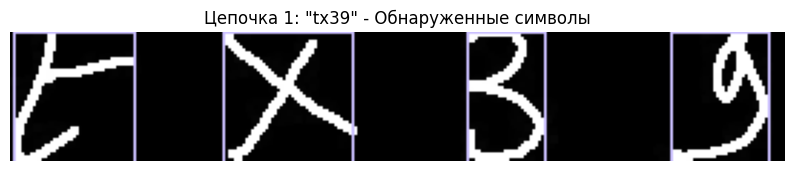

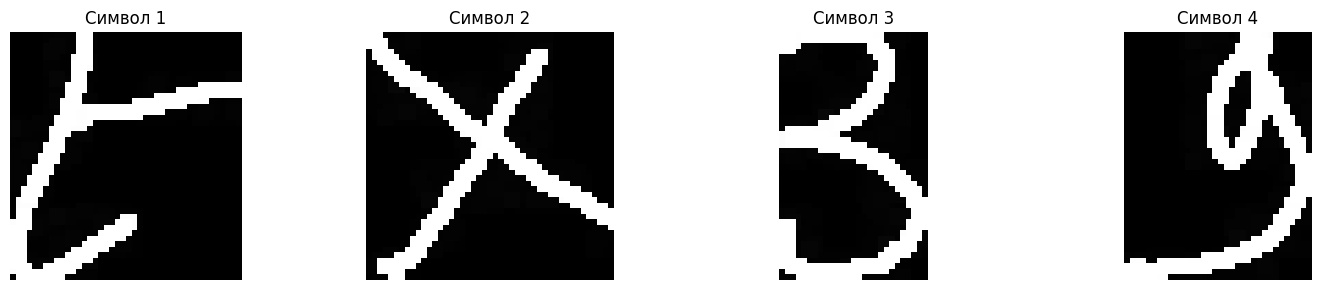

✓ Найдено символов: 4

Обрабатываем цепочку 2: '2513'


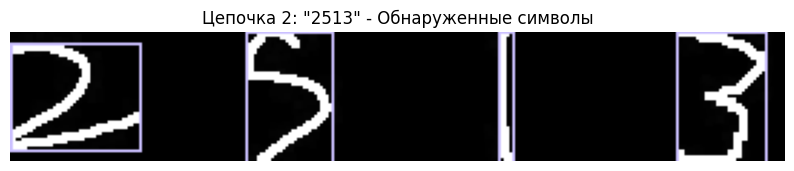

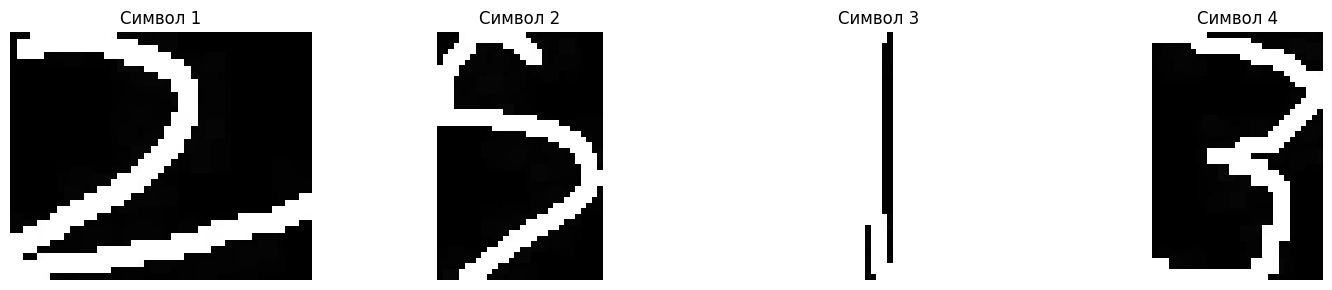

✓ Найдено символов: 4

Обрабатываем цепочку 3: '499-'


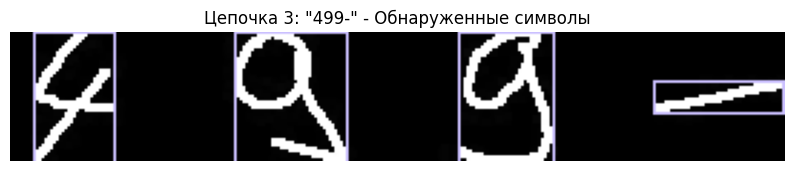

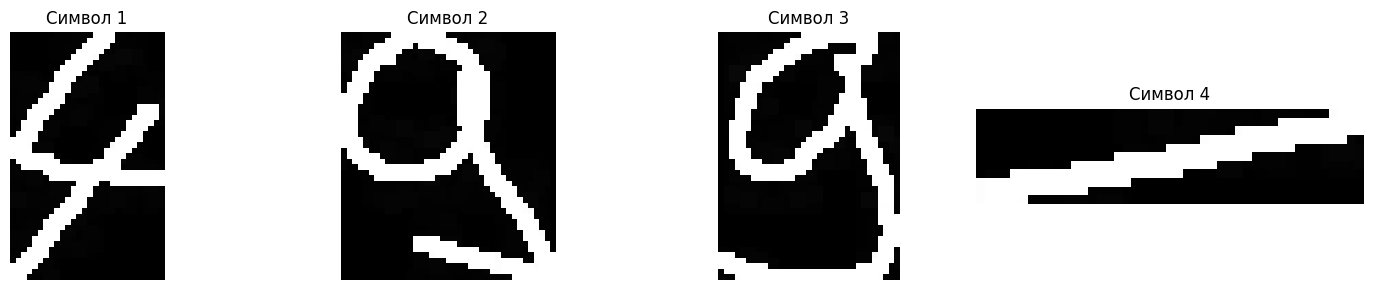

✓ Найдено символов: 4

ОБРАБОТАННЫЕ ЦЕПОЧКИ:
1. 'tx39' - 4 символов
2. '2513' - 4 символов
3. '499-' - 4 символов


In [27]:
# PART 4: Image Preprocessing and Segmentation

def preprocess_image(image):
    """Применяет морфологические операции к изображению"""
    kernel = np.ones((3, 3), np.uint8)
    processed = cv2.erode(image, kernel, iterations=1)
    processed = cv2.bitwise_not(processed)
    return processed

def extract_characters(binary_image, processed_image):
    """Находит контуры символов и извлекает их ограничивающие прямоугольники"""
    contours, _ = cv2.findContours(binary_image[:, :, 0], cv2.RETR_EXTERNAL, 2)
    
    # Сортируем контуры слева направо
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    
    bboxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        w = min(w, 45)  # Ограничиваем ширину
        
        if w * h > 50:  # Фильтруем маленькие контуры
            bboxes.append((x, y, w, h))
    
    return bboxes

def process_character_chain(processed_image, sequence):
    """Полная обработка цепочки: бинаризация, сегментация, извлечение символов"""
    # Преобразуем в RGB для отображения
    rgb_image = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2RGB)
    
    # Бинаризация
    _, binary = cv2.threshold(rgb_image, 127, 255, 0)
    
    # Извлечение bounding boxes
    bboxes = extract_characters(binary, processed_image)
    
    # Рисуем прямоугольники
    for x, y, w, h in bboxes:
        cv2.rectangle(rgb_image, (x, y), (x+w, y+h), (203, 192, 255), 1)
    
    # Извлекаем изображения символов
    extracted_chars = []
    for x, y, w, h in bboxes:
        char_img = processed_image[y:y+h, x:x+w]
        extracted_chars.append((x, char_img))
    
    return rgb_image, binary, extracted_chars, bboxes

def process_all_chains(final_images, sequences):
    """Обрабатывает все цепочки и собирает данные"""
    processed_data = []
    
    for idx, (image, sequence) in enumerate(zip(final_images, sequences)):
        print(f"Обрабатываем цепочку {idx + 1}: '{sequence}'")
        
        # Предварительная обработка
        processed = preprocess_image(image)
        
        # Полная обработка цепочки
        rgb_marked, binary, extracted, bboxes = process_character_chain(processed, sequence)
        
        # Визуализация обнаруженных символов
        plt.figure(figsize=(10, 3))
        plt.imshow(rgb_marked)
        plt.title(f'Цепочка {idx + 1}: "{sequence}" - Обнаруженные символы')
        plt.axis('off')
        plt.show()
        
        # Визуализация извлеченных символов
        fig, axes = plt.subplots(1, len(extracted), figsize=(15, 3))
        if len(extracted) == 1:
            axes = [axes]
        
        for char_idx, (_, char_img) in enumerate(extracted):
            axes[char_idx].imshow(char_img, cmap='gray')
            axes[char_idx].set_title(f'Символ {char_idx + 1}')
            axes[char_idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Сохраняем данные
        processed_data.append({
            'sequence': sequence,
            'characters': extracted,
            'count': len(extracted)
        })
        
        print(f"✓ Найдено символов: {len(extracted)}\n")
    
    return processed_data

# Обработка всех цепочек
processed_sequences_data = process_all_chains(final_combined_images, generated_sequences)

# Итоговая информация
print("=" * 50)
print("ОБРАБОТАННЫЕ ЦЕПОЧКИ:")
for idx, data in enumerate(processed_sequences_data):
    print(f"{idx + 1}. '{data['sequence']}' - {data['count']} символов")


In [28]:
# PART 5: Preparing Training Data

def load_training_data(dataset_dir, characters, train_ratio=0.8):
    """Загружает обучающие данные из датасета"""
    features, labels = [], []
    
    for char in characters:
        # Обработка специального случая 'x' -> 'X'
        folder_name = 'X' if char == 'x' else char
        char_path = os.path.join(dataset_dir, folder_name)
        
        # Получаем список файлов
        images = sorted([f for f in os.listdir(char_path) 
                        if os.path.isfile(os.path.join(char_path, f))])
        
        # Разделяем на обучающий и валидационный наборы
        split_idx = int(len(images) * train_ratio)
        train_images = images[:split_idx]
        
        # Загружаем и преобразуем в вектор признаков
        for img_file in train_images:
            img_path = os.path.join(char_path, img_file)
            img_data = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img_data is not None:
                features.append(img_data.flatten())
                labels.append(char)
    
    return np.array(features), np.array(labels)

def prepare_training_dataset(dataset_dir, characters):
    """Подготавливает полный обучающий датасет"""
    X_train, y_train = load_training_data(dataset_dir, characters, train_ratio=0.8)
    
    print(f"Обучающая выборка загружена: {len(X_train)} изображений")
    print(f"Количество классов: {len(np.unique(y_train))}")
    print(f"Размерность признаков: {X_train.shape[1]}")
    
    return X_train, y_train

# Список символов для обучения
TRAINING_CHARS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
                   '+', '-', '*', 't', 'x', 'y', 'w', 'h', '(', ')', ',']

# Загрузка данных
X_train, y_train = prepare_training_dataset('./data', TRAINING_CHARS)


Обучающая выборка загружена: 180225 изображений
Количество классов: 21
Размерность признаков: 2025


In [29]:
# PART 6: Training KNN Models

def train_knn_models(X_train, y_train, k_values):
    """Обучает несколько KNN моделей с разными значениями k"""
    models = {}
    
    for k in k_values:
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        models[k] = classifier
        print(f"Модель KNN (k={k}) обучена")
    
    return models

def classify_character_image(model, char_img, target_size=(45, 45)):
    """Классифицирует отдельный символ с помощью модели"""
    # Изменяем размер
    resized = cv2.resize(char_img, target_size)
    
    # Инвертируем
    processed = cv2.bitwise_not(resized)
    
    # Преобразуем в вектор признаков
    features = processed.flatten()
    
    # Проверяем размерность
    if len(features) != model.n_features_in_:
        print(f"Размерность не совпадает: ожидалось {model.n_features_in_}, получено {len(features)}")
    
    # Предсказываем
    prediction = model.predict([features])
    return prediction[0]

# Обучение моделей
K_VALUES = [1, 3, 5, 7]
print("Обучение моделей KNN...")
knn_models = train_knn_models(X_train, y_train, K_VALUES)
print()


Обучение моделей KNN...
Модель KNN (k=1) обучена
Модель KNN (k=3) обучена
Модель KNN (k=5) обучена
Модель KNN (k=7) обучена



In [30]:
# PART 7: Model Evaluation and Performance Comparison

def rate_model(model, processed_data):
    """Оценивает производительность модели на обработанных цепочках"""
    correct_total = 0
    total_chars = 0
    sequence_results = []
    
    for data in processed_data:
        original_seq = data['sequence']
        characters = data['characters']
        
        # Классифицируем каждый символ
        predicted_chars = []
        for _, char_img in characters:
            resized = cv2.resize(char_img, (45, 45))
            predicted = classify_character_image(model, resized)
            predicted_chars.append(predicted)
        
        predicted_seq = ''.join(predicted_chars)
        
        # Подсчитываем правильные предсказания
        correct_count = sum(1 for orig, pred in zip(original_seq, predicted_seq) 
                           if orig == pred)
        correct_total += correct_count
        total_chars += len(original_seq)
        
        # Сохраняем результат для этой цепочки
        is_correct = original_seq == predicted_seq
        sequence_results.append({
            'original': original_seq,
            'predicted': predicted_seq,
            'correct': is_correct,
            'accuracy': correct_count / len(original_seq)
        })
    
    overall_accuracy = correct_total / total_chars if total_chars > 0 else 0
    
    return {
        'accuracy': overall_accuracy,
        'correct_chars': correct_total,
        'total_chars': total_chars,
        'sequences': sequence_results
    }

def compare_models(knn_models, processed_data):
    """Сравнивает производительность всех моделей"""
    results = {}
    
    print("=" * 70)
    print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ МОДЕЛЕЙ")
    print("=" * 70)
    
    for k, model in knn_models.items():
        print(f"\n{'─' * 70}")
        print(f"МОДЕЛЬ: K={k}")
        print(f"{'─' * 70}")
        
        evaluation = rate_model(model, processed_data)
        results[k] = evaluation
        
        # Вывод результатов по цепочкам
        for seq_idx, seq_result in enumerate(evaluation['sequences']):
            print(f"\nЦепочка {seq_idx + 1}:")
            print(f"  Исходный текст:     '{seq_result['original']}'")
            print(f"  Распознанный текст: '{seq_result['predicted']}'")
            
            if seq_result['correct']:
                print(f"  ✓ Полное совпадение")
            else:
                print(f"  ✗ Ошибки найдены:")
                for pos, (orig, pred) in enumerate(zip(seq_result['original'], 
                                                        seq_result['predicted'])):
                    if orig != pred:
                        print(f"     Позиция {pos + 1}: '{orig}' → '{pred}'")
        
        # Итоги для модели
        print(f"\nИтоги для K={k}:")
        print(f"  Правильно распознано: {evaluation['correct_chars']}/{evaluation['total_chars']}")
        print(f"  Точность: {evaluation['accuracy']:.2%}")
        correct_sequences = sum(1 for s in evaluation['sequences'] if s['correct'])
        print(f"  Верных цепочек: {correct_sequences}/{len(evaluation['sequences'])}")
    
    return results

def select_optimal_model(results):
    """Выбирает модель с наилучшей производительностью"""
    print("\n" + "=" * 70)
    print("ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЗНАЧЕНИЯ K")
    print("=" * 70 + "\n")
    
    for k, result in sorted(results.items()):
        print(f"K={k}: Точность {result['accuracy']:.2%} "
              f"({result['correct_chars']}/{result['total_chars']} символов)")
    
    optimal_k = max(results.keys(), key=lambda k: results[k]['accuracy'])
    optimal_accuracy = results[optimal_k]['accuracy']
    
    print(f"\n{'─' * 70}")
    print(f"✓ ОПТИМАЛЬНАЯ МОДЕЛЬ: K={optimal_k} с точностью {optimal_accuracy:.2%}")
    print(f"{'─' * 70}")
    
    return optimal_k, optimal_accuracy

# Оценка и сравнение моделей
model_results = compare_models(knn_models, processed_sequences_data)
optimal_k, optimal_accuracy = select_optimal_model(model_results)

print(f"\nРЕКОМЕНДАЦИЯ: Используйте KNN модель с K={optimal_k}")


СРАВНИТЕЛЬНЫЙ АНАЛИЗ МОДЕЛЕЙ

──────────────────────────────────────────────────────────────────────
МОДЕЛЬ: K=1
──────────────────────────────────────────────────────────────────────

Цепочка 1:
  Исходный текст:     'tx39'
  Распознанный текст: 'tx39'
  ✓ Полное совпадение

Цепочка 2:
  Исходный текст:     '2513'
  Распознанный текст: '23h3'
  ✗ Ошибки найдены:
     Позиция 2: '5' → '3'
     Позиция 3: '1' → 'h'

Цепочка 3:
  Исходный текст:     '499-'
  Распознанный текст: '-23-'
  ✗ Ошибки найдены:
     Позиция 1: '4' → '-'
     Позиция 2: '9' → '2'
     Позиция 3: '9' → '3'

Итоги для K=1:
  Правильно распознано: 7/12
  Точность: 58.33%
  Верных цепочек: 1/3

──────────────────────────────────────────────────────────────────────
МОДЕЛЬ: K=3
──────────────────────────────────────────────────────────────────────

Цепочка 1:
  Исходный текст:     'tx39'
  Распознанный текст: 'tx39'
  ✓ Полное совпадение

Цепочка 2:
  Исходный текст:     '2513'
  Распознанный текст: '23h3'
  ✗ Ошибки 